# Bayesian Kriging to Predict Ground Water Levels

In [1]:
from __future__ import absolute_import, division, print_function

import os
import pyro
import torch
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import pyro.optim as optim
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch.distributions import constraints

from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from mpl_toolkits.mplot3d import Axes3D
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO

pyro.set_rng_seed(0)

In [2]:
%matplotlib inline
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Enable validation checks
pyro.enable_validation(True)
smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("0.4.1")

In [3]:
pyro.set_rng_seed(1)

### Helper Functions

In [4]:
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    # if y is None:
    #     dist = dist - torch.diag(dist.diag)
    return torch.clamp(dist, 0.0, np.inf)

In [5]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [6]:
def visualize_data(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
):

    ax = plt.figure().add_subplot(111, projection='3d')
    
    if plot_observed_data:
        ax.scatter(XW[:, 0], XW[:, 1], YW, marker="x")
        ax.scatter(XF[:, 0], XF[:, 1], YF, marker="o")
        
    if plot_predictions:
        Xtest_ltd = torch.linspace(0, 5, n_test)
        Xtest_lng = torch.linspace(0, 10, n_test)
        
        Xtest_ltd, Xtest_lng = np.meshgrid(Xtest_ltd, Xtest_lng)
        
        Xtest_ltd = np.expand_dims(Xtest_ltd, -1)
        Xtest_lng = np.expand_dims(Xtest_lng, -1)
        
        Xtest = np.concatenate([Xtest_ltd, Xtest_lng], -1).reshape((-1, 2))
        
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
                
        print(mean, cov)
                
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        plt.fill_between(
            Xtest,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest_ltd = torch.linspace(0, 5, n_test)
        Xtest_lng = torch.linspace(0, 10, n_test)
        
        Xtest_ltd, Xtest_lng = np.meshgrid(Xtest_ltd, Xtest_lng)
        
        Xtest_ltd = np.expand_dims(Xtest_ltd, -1)
        Xtest_lng = np.expand_dims(Xtest_lng, -1)
        
        Xtest = np.concatenate([Xtest_ltd, Xtest_lng], -1).reshape((-1, 2))
        Xtest = torch.tensor(Xtest)
        
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

#     plt.xlim(-0.5, 5.5)

In [9]:
def visualize_posterior(samples):
    import math
    
    sites = list(samples.keys())
    
    r = int(math.ceil(math.sqrt(len(samples))))
    fig, axs = plt.subplots(nrows=r, ncols=r, figsize=(12, 10))
    fig.suptitle("Marginal Posterior Density", fontsize=16)
    
    
    for i, ax in enumerate(axs.reshape(-1)):
        site = sites[i]
        sns.distplot(samples[site], ax=ax)
        ax.set_title(site)
        
    handles, labels = ax.get_legend_handles_labels()

### Loading Data

In [7]:
data = pd.read_csv("data/sample_data.csv", encoding="ISO-8859-1")

data_wells = data[data.type == "well"]
data_farms = data[data.type == "farm"]

XW = torch.tensor(data_wells[["latitude", "longitude"]].values)
YW = torch.tensor(data_wells["observation"].values)

XF = torch.tensor(data_farms[["latitude", "longitude"]].values)
YF = torch.tensor(data_farms["observation"].values)

In [8]:
# plot(plot_observed_data=True)
# plt.show()

# Bayesian Kernel Regression

## Defining the Model

In [10]:
def model_kr(XW, YW):
    mu_delta = 1
    mu_theta = 0
    
    delta = -pyro.sample("delta", dist.LogNormal(mu_delta, 0.5))
    theta = pyro.sample("theta", dist.LogNormal(mu_theta, 0.5))
    
    sigma_mu = 2
    mu = pyro.sample("mu", dist.Normal(0, sigma_mu))
    
    sigma = pyro.sample("sigma", dist.Gamma(1, 1))
    mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1) * delta + mu
    
    with pyro.plate("data", len(YW)):
        y = pyro.sample("obs", dist.Normal(mean, sigma), obs=YW)
    
    return y

In [11]:
def guide_kr(XW, YW):
    mu_delta = pyro.param("mu_delta", torch.ones(1), constraint=constraints.positive)
    mu_theta = pyro.param("mu_theta", torch.zeros(1), constraint=constraints.positive)
    
    sg_delta = pyro.param("sg_delta", torch.ones(1), constraint=constraints.positive)
    sg_theta = pyro.param("sg_theta", torch.ones(1), constraint=constraints.positive)
    
    delta = -pyro.sample("delta", dist.Normal(mu_delta, sg_delta))
    theta = pyro.sample("theta", dist.Normal(mu_theta, sg_theta))
    
    mu_sigma = pyro.param("mu_sigma", torch.tensor(1.0), constraint=constraints.positive)
    sigma = pyro.sample("sigma", dist.Normal(mu_sigma, torch.tensor(0.05)))
    
    mu_mu = pyro.param("mu_mu", torch.randn(1))
    sg_mu = pyro.param("sg_mu", torch.ones(1), constraint=constraints.positive)
    mu = pyro.sample("mu", dist.Normal(mu_mu, sg_mu))
    
    mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1) * delta + mu

In [18]:
def predict_kr(XW, posterior_samples):
    ps = posterior_samples
    samples = zip(ps["delta"], ps["theta"], ps["mu"], ps["sigma"])
    
    for delta, theta, mu, sigma in samples:
        mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1) * delta + mu
        yield dist.Normal(mean, sigma).sample()

## Inference

In [13]:
nuts_kernel = NUTS(model_kr)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(XW, YW)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [00:19<00:00, 60.93it/s, step size=5.60e-01, acc. prob=0.724]


In [14]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: delta
       mean       std        5%       25%       50%      75%       95%
0  2.065354  0.980866  1.049756  1.440756  1.847087  2.37423  3.743856 

Site: theta
       mean       std        5%       25%       50%       75%       95%
0  1.301621  0.666623  0.443629  0.781652  1.163321  1.758938  2.507548 

Site: mu
       mean       std        5%       25%       50%       75%       95%
0 -2.150458  0.493366 -2.959502 -2.468774 -2.171524 -1.847485 -1.211475 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.926068  0.265573  0.593059  0.732821  0.876964  1.057468  1.444145 



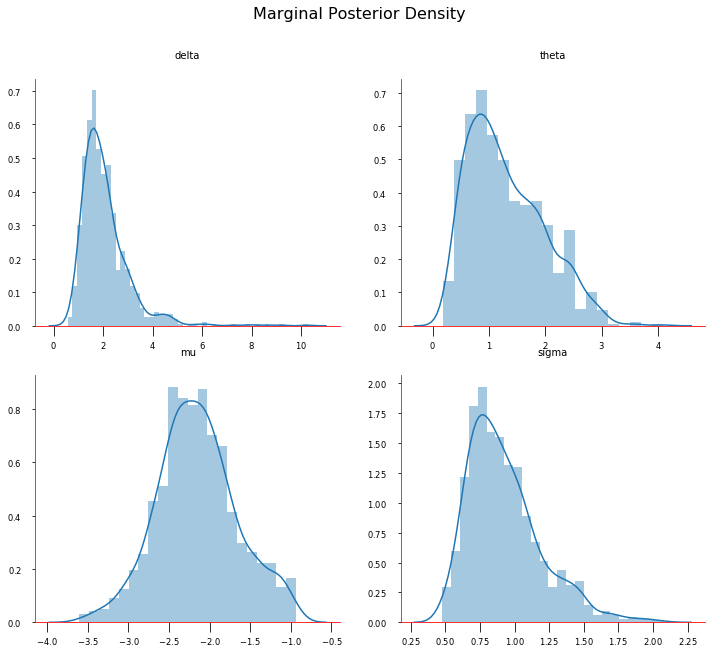

In [15]:
visualize_posterior(hmc_samples)

In [ ]:
# svi = SVI(
#     model, guide, optim.Adam({"lr": 0.005}), loss=JitTrace_ELBO(), num_samples=1000
# )

# pyro.clear_param_store()
# num_iters = 10000 if not smoke_test else 2
# for i in range(num_iters):
#     elbo = svi.step(XW, YW)
#     if i % 500 == 0:
#         logging.info("Elbo loss: {}".format(elbo))

## Prediction

In [19]:
results = torch.stack(list(predict_kr(XW, hmc_samples)))

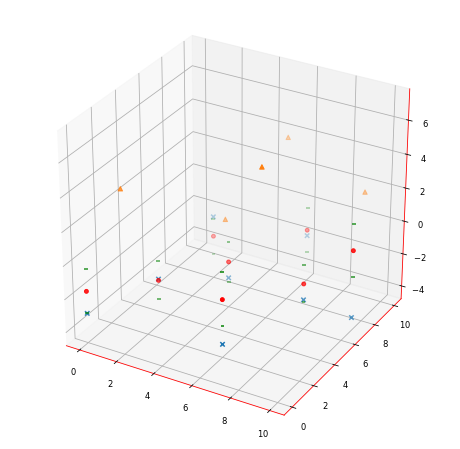

In [20]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection='3d')

ax.scatter(XW[:, 0], XW[:, 1], YW, marker="x")
ax.scatter(XF[:, 0], XF[:, 1], YF, marker="^")

# for result in results[:100]:
#     ax.scatter(XW[:, 0], XW[:, 1], result, marker=".", color="red")
    
results_mean = results.mean(dim=0).numpy()
results_std = results.std(dim=0).numpy()

ax.scatter(XW[:, 0], XW[:, 1], results_mean, marker="o", color="red", s=15)

ax.scatter(XW[:, 0], XW[:, 1], results_mean - results_std, marker="_", color="green", s=15)
# for i, point in enumerate(XW.numpy().tolist()):
#     ax.plot(point + [results_mean[i] + results_std[i]], point + [results_mean[i] - results_std[i]])
ax.scatter(XW[:, 0], XW[:, 1], results_mean + results_std, marker="_", color="green", s=15)
    
plt.savefig("predictions.png", dpi=240)
plt.show()

# Gaussian Processes

## Defining the Model

In [44]:
def model_gp(XW, YW):
    mu_delta = 1
    
    delta = -pyro.sample("delta", dist.LogNormal(mu_delta, 0.5))
    
    mu_theta_f = 0
    mu_theta_w = 0
    
    theta_f = pyro.sample("theta_f", dist.LogNormal(mu_theta_f, 0.5))
    theta_w = pyro.sample("theta_w", dist.LogNormal(mu_theta_w, 0.5))
    
    sigma_mu = 2
    mu = pyro.sample("mu", dist.Normal(0, sigma_mu))
    
    sigma = torch.exp(-pairwise_distances(XW, XW) / theta_w)
    mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta_f)).sum(1) * delta + mu
    
    with pyro.plate("data", len(YW)):
        y = pyro.sample("obs", dist.MultivariateNormal(mean, sigma), obs=YW)
    
    return y

In [26]:
def guide_gp(XW, YW):
    mu_delta = pyro.param("mu_delta", torch.ones(1), constraint=constraints.positive)
    mu_theta_f = pyro.param("mu_theta_f", torch.zeros(1), constraint=constraints.positive)
    mu_theta_w = pyro.param("mu_theta_w", torch.zeros(1), constraint=constraints.positive)
    
    sg_delta = pyro.param("sg_delta", torch.ones(1), constraint=constraints.positive)
    sg_theta_f = pyro.param("sg_theta_f", torch.ones(1), constraint=constraints.positive)
    sg_theta_w = pyro.param("sg_theta_w", torch.ones(1), constraint=constraints.positive)
    
    delta = -pyro.sample("delta", dist.Normal(mu_delta, sg_delta))
    
    theta_f = pyro.sample("theta_f", dist.Normal(mu_theta, sg_theta))
    theta_w = pyro.sample("theta_w", dist.Normal(mu_theta, sg_theta))
    
    mu_mu = pyro.param("mu_mu", torch.randn(1))
    sg_mu = pyro.param("sg_mu", torch.ones(1), constraint=constraints.positive)
    mu = pyro.sample("mu", dist.MultivariateNormal(mu_mu, sg_mu))
    
    mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta_f)).sum(1) * delta + mu

In [42]:
def predict_gp(XW, posterior_samples):
    ps = posterior_samples
    samples = zip(ps["delta"], ps["theta_f"], ps["theta_w"], ps["mu"])
    
    for delta, theta_f, theta_w, mu in samples:
        sigma = torch.exp(-pairwise_distances(XW, XW) / theta_w)
        print(sigma.shape)
        mean = (YF * torch.exp(-pairwise_distances(XW, XF) / theta_f)).sum(1) * delta + mu
        yield dist.Normal(mean, sigma).sample()

## Training the Model

In [ ]:
nuts_kernel = NUTS(model_gp)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(XW, YW)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample:  78%|███████▊  | 933/1200 [00:55<00:15, 17.36it/s, step size=2.48e-01, acc. prob=0.935]

In [30]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: delta
       mean      std        5%       25%       50%      75%       95%
0  1.088525  0.10724  0.919179  1.015363  1.084821  1.15578  1.278453 

Site: theta_f
       mean       std        5%       25%      50%       75%       95%
0  3.174725  0.417195  2.553395  2.872811  3.15362  3.431015  3.923453 

Site: theta_w
        mean       std         5%        25%        50%        75%         95%
0  97.345284  9.210999  83.431062  90.817034  96.663086  102.69276  113.511074 

Site: mu
       mean       std        5%       25%       50%       75%       95%
0 -1.419281  0.207745 -1.747346 -1.572017 -1.425605 -1.264144 -1.086513 



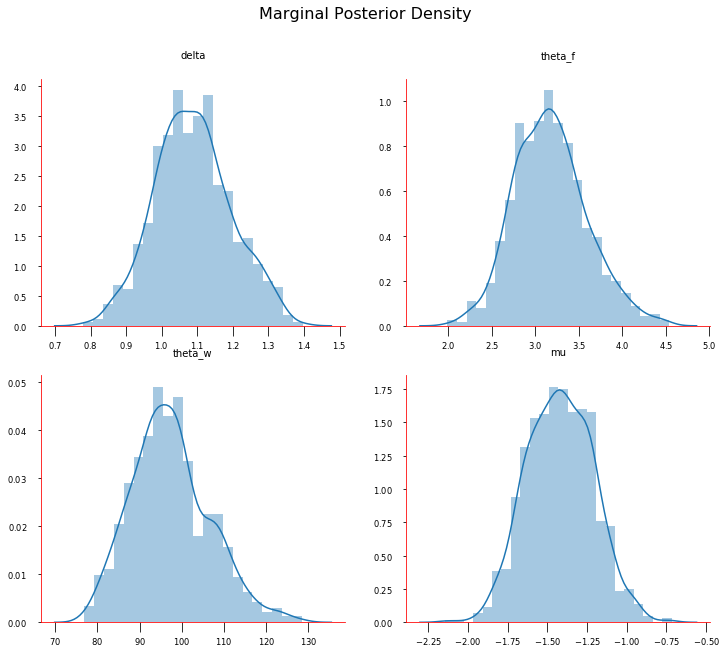

In [31]:
visualize_posterior(hmc_samples)

In [43]:
results = torch.stack(list(predict_gp(XW, hmc_samples)))

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])


In [41]:
results.shape

torch.Size([1000, 8, 8])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

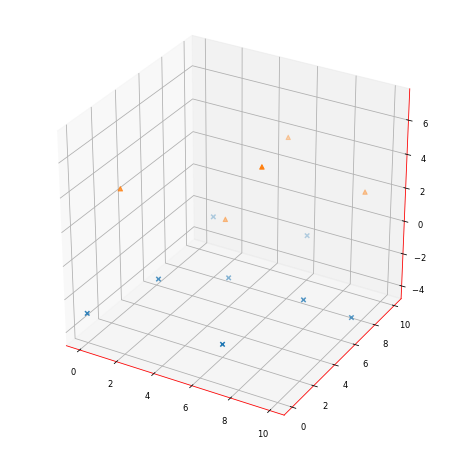

In [39]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection='3d')

ax.scatter(XW[:, 0], XW[:, 1], YW, marker="x")
ax.scatter(XF[:, 0], XF[:, 1], YF, marker="^")

# for result in results[:100]:
#     ax.scatter(XW[:, 0], XW[:, 1], result, marker=".", color="red")

results_mean = results.mean(dim=0).numpy()
results_std = results.std(dim=0).numpy()

ax.scatter(XW[:, 0], XW[:, 1], results_mean, marker="o", color="red", s=15)

ax.scatter(XW[:, 0], XW[:, 1], results_mean - results_std, marker="_", color="green", s=15)
# for i, point in enumerate(XW.numpy().tolist()):
#     ax.plot(point + [results_mean[i] + results_std[i]], point + [results_mean[i] - results_std[i]])
ax.scatter(XW[:, 0], XW[:, 1], results_mean + results_std, marker="_", color="green", s=15)
    
plt.savefig("predictions.png", dpi=240)
plt.show()